In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures

import wrangle
import explore
import modelling

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# 6037 Los Angeles County
# 6111 Ventura County
# 6059 Orange County

In [2]:
# acquire data and split data using a function from wrangle module
zillow = wrangle.get_zillow()


In [3]:
zillow.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips
0,3.5,4.0,3100.0,1023282.0,6059.0
1,1.0,2.0,1465.0,464000.0,6111.0
2,2.0,3.0,1243.0,564778.0,6059.0
3,3.0,4.0,2376.0,145143.0,6037.0
4,3.0,4.0,2962.0,773303.0,6037.0


In [4]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   52442 non-null  float64
 1   bedroomcnt                    52442 non-null  float64
 2   calculatedfinishedsquarefeet  52360 non-null  float64
 3   taxvaluedollarcnt             52441 non-null  float64
 4   fips                          52442 non-null  float64
dtypes: float64(5)
memory usage: 2.0 MB


In [5]:
zillow.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips
count,52442.000000,52442.000000,52360.000000,5.244100e+04,52442.000000
mean,2.299397,3.300675,1922.874083,5.296830e+05,6049.131917
std,1.022764,0.949086,1004.363491,7.518883e+05,21.028933
min,0.000000,0.000000,128.000000,1.000000e+03,6037.000000
25%,2.000000,3.000000,1268.000000,1.937500e+05,6037.000000
50%,2.000000,3.000000,1659.000000,3.736120e+05,6037.000000
75%,3.000000,4.000000,2306.000000,6.193010e+05,6059.000000
max,18.000000,14.000000,21929.000000,4.906124e+07,6111.000000


In [6]:
def get_outliers(df):
    for col in df.columns.tolist():
        sns.boxplot(x=col, data=df)
        plt.show()

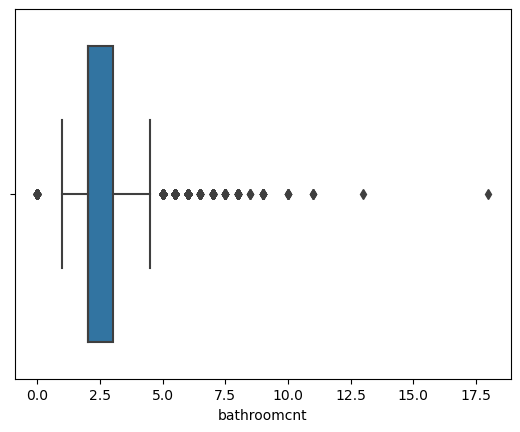

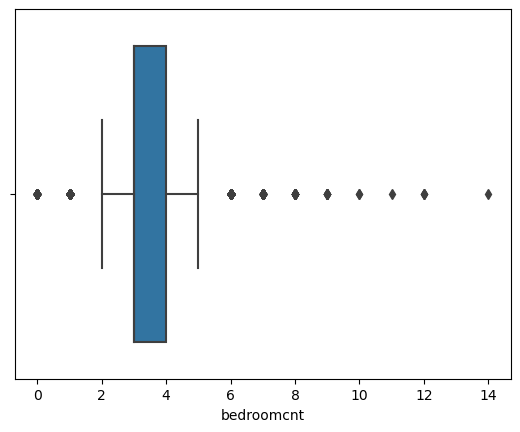

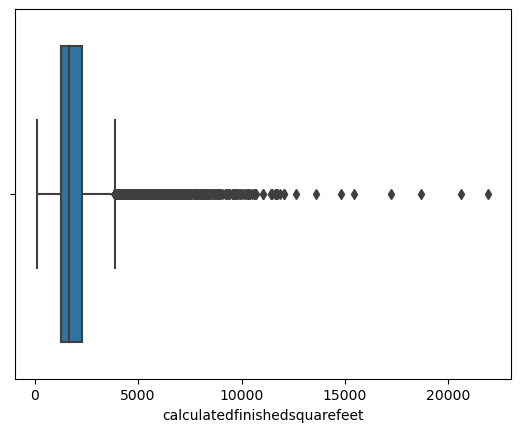

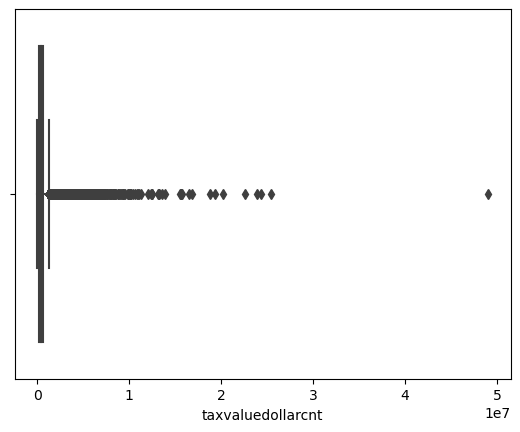

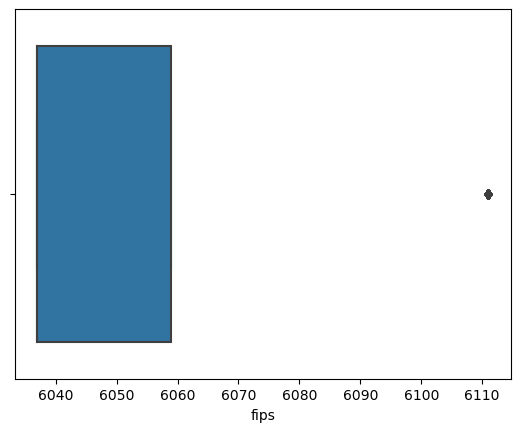

In [7]:
get_outliers(zillow)

In [8]:
clean_zillow = wrangle.get_clean_zillow(zillow)

In [9]:
clean_zillow.head()

,bathroom,bedroom,sqft,tax_amount,county,Los Angeles,Orange,Ventura
287,1.0,1.0,784.0,188067.0,Los Angeles,1,0,0
600,1.0,1.0,745.0,192000.0,Los Angeles,1,0,0
695,1.0,1.0,1088.0,217558.0,Los Angeles,1,0,0
706,1.0,1.0,830.0,390085.0,Los Angeles,1,0,0
760,1.0,1.0,976.0,368553.0,Los Angeles,1,0,0


In [10]:
def create_dummies(cols,df):
    
    dummies = pd.get_dummies(df[cols])
    df = pd.concat([df, dummies],axis=1)
    return df

In [11]:
clean_zillow = create_dummies('county',clean_zillow)

In [12]:
clean_zillow.head()

,bathroom,bedroom,sqft,tax_amount,county,Los Angeles,Orange,Ventura,Los Angeles,Orange,Ventura
287,1.0,1.0,784.0,188067.0,Los Angeles,1,0,0,1,0,0
600,1.0,1.0,745.0,192000.0,Los Angeles,1,0,0,1,0,0
695,1.0,1.0,1088.0,217558.0,Los Angeles,1,0,0,1,0,0
706,1.0,1.0,830.0,390085.0,Los Angeles,1,0,0,1,0,0
760,1.0,1.0,976.0,368553.0,Los Angeles,1,0,0,1,0,0


In [13]:
train, validate, test = wrangle.train_val_test(clean_zillow, seed=42)
train.shape, validate.shape, test.shape

((26227, 11), (11241, 11), (9367, 11))

In [14]:
train.county.value_counts()

Los Angeles    16937
Orange          7079
Ventura         2211
Name: county, dtype: int64

In [15]:
# train.bathroom.value_counts()

In [16]:
# train.bedroom.value_counts()

In [17]:
# create the corelation matrix
train_zillow_corr = train.corr(method='spearman')
train_zillow_corr

,bathroom,bedroom,sqft,tax_amount,Los Angeles,Orange,Ventura,Los Angeles,Orange,Ventura
bathroom,1.000000,0.564971,0.759719,0.339350,-0.096032,0.076048,0.043805,-0.096032,0.076048,0.043805
bedroom,0.564971,1.000000,0.615516,0.194864,-0.170729,0.118118,0.105173,-0.170729,0.118118,0.105173
sqft,0.759719,0.615516,1.000000,0.422978,-0.210183,0.166906,0.095137,-0.210183,0.166906,0.095137
tax_amount,0.339350,0.194864,0.422978,1.000000,-0.197233,0.168454,0.070373,-0.197233,0.168454,0.070373
Los Angeles,-0.096032,-0.170729,-0.210183,-0.197233,1.000000,-0.820984,-0.409689,1.000000,-0.820984,-0.409689
Orange,0.076048,0.118118,0.166906,0.168454,-0.820984,1.000000,-0.184488,-0.820984,1.000000,-0.184488
Ventura,0.043805,0.105173,0.095137,0.070373,-0.409689,-0.184488,1.000000,-0.409689,-0.184488,1.000000
Los Angeles,-0.096032,-0.170729,-0.210183,-0.197233,1.000000,-0.820984,-0.409689,1.000000,-0.820984,-0.409689
Orange,0.076048,0.118118,0.166906,0.168454,-0.820984,1.000000,-0.184488,-0.820984,1.000000,-0.184488
Ventura,0.043805,0.105173,0.095137,0.070373,-0.409689,-0.184488,1.000000,-0.409689,-0.184488,1.000000


In [18]:
def get_corelation_map(df):
    corr = df.corr(method='spearman')
    sns.heatmap(corr, cmap='Purples', annot=True, mask= np.triu(corr))
    


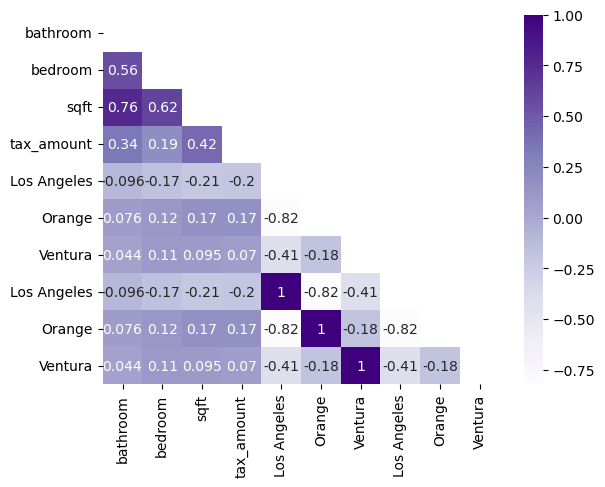

In [19]:
get_corelation_map(train)

In [20]:
# def get_histplot(col,df):
#     sns.histplot(x=col, hue='county', data=df,element='step')

In [21]:
# def get_boxplot(col,df):
#     sns.boxplot(x=col, data=df)

In [22]:
train.head()

,bathroom,bedroom,sqft,tax_amount,county,Los Angeles,Orange,Ventura,Los Angeles,Orange,Ventura
24005,3.0,4.0,2815.0,349000.0,Los Angeles,1,0,0,1,0,0
10859,2.0,2.0,1973.0,793000.0,Los Angeles,1,0,0,1,0,0
40615,2.0,3.0,1517.0,127619.0,Los Angeles,1,0,0,1,0,0
44400,2.0,3.0,1316.0,488770.0,Los Angeles,1,0,0,1,0,0
47188,2.0,2.0,1416.0,305739.0,Orange,0,1,0,0,1,0


In [23]:
def get_barplot_county(df):
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x='county', y='tax_amount', data=df)
    avg_tax_amount = df.tax_amount.mean()
    plt.axhline(avg_tax_amount, label="Avg_house_value = 4.22K", color='yellow')
    plt.legend()
    # plt.xticks(ticks = [0, 6037.0, 6059.0, 6111.0], labels=['k','Los Angeles', 'Orange', 'Ventura'])
    plt.yticks(ticks = [0,100000,200000,300000,400000,500000,600000], labels=['0', '100K ', '200K', '300K', '400K', '500K', '600K'])
    plt.ylabel('Home  Value  ($)')
    plt.title('House Value across counties')
    ax.spines[['right', 'top']].set_visible(False)
    plt.show()

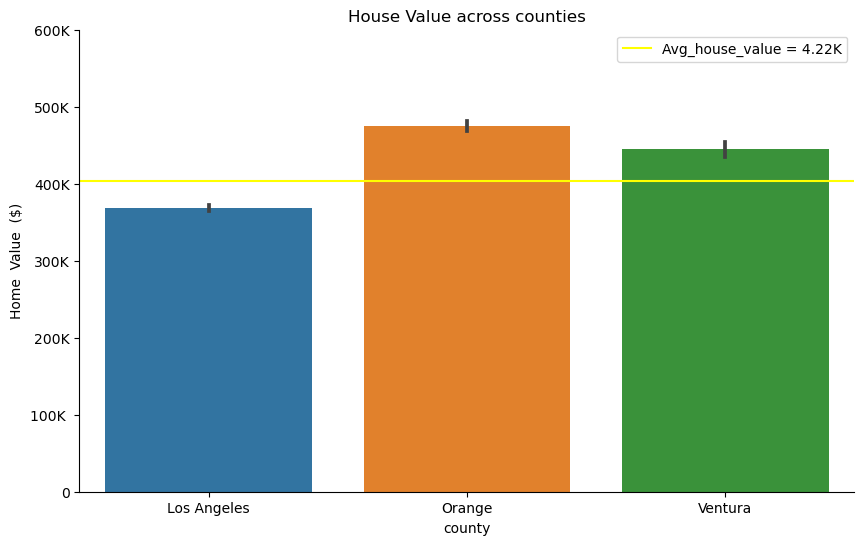

In [24]:
get_barplot_county(train)

In [25]:
def get_barplot_bathroom_bedroom(df):
    plt.figure(figsize=(8,10))
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
    plt.subplot(211)
    ax = sns.barplot(x='tax_amount',y='bathroom', data=df, color='steelblue', orient='h' )
    median = df.bathroom.median()
    plt.annotate(f' Median bathroom: {median}',(200000,2))
    plt.xticks(ticks = [0,100000,200000,300000,400000,500000, 600000,700000, 800000], labels=['0', '100K ', '200K', '300K', '400K', '500K', '600K','700K', '800K'])
    plt.xlabel('Home  Value  ($)')
    plt.ylabel('Number of bathroom')
    plt.ylim(-1,5)
    ax.spines[['right', 'top']].set_visible(False)
    plt.title("Home value with number of bathroom")
    
    plt.subplot(212)
    ax = sns.barplot(x='tax_amount',y='bedroom', data=df, color='skyblue', orient='h' )
    median = df.bedroom.median()
    plt.annotate(f' Median bedroom: {median}',(100000,1))
    plt.xticks(ticks = [0,100000,200000,300000,400000,500000, 600000,700000, 800000], labels=['0', '100K ', '200K', '300K', '400K', '500K', '600K','700K', '800K'])
    plt.xlabel('Home  Value  ($)')
    plt.ylabel('Number of bedroom')
    plt.ylim(-1,5)
    ax.spines[['right', 'top']].set_visible(False)
    plt.title("Home value with number of bedroom")
    plt.show()

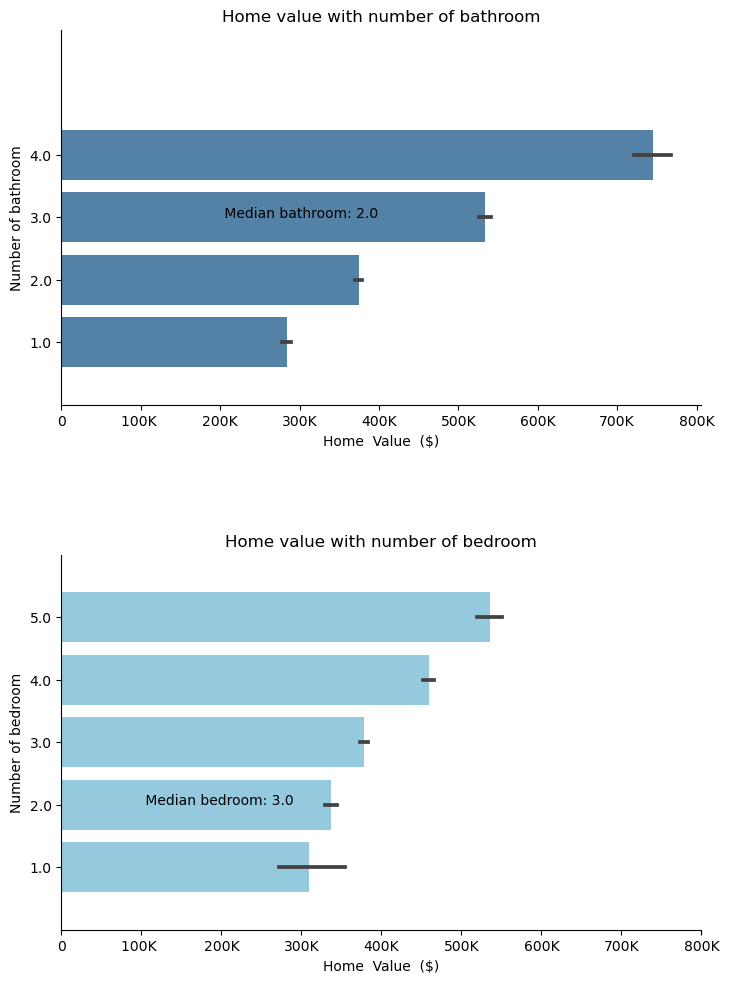

In [26]:
get_barplot_bathroom_bedroom(train)

In [27]:
def get_barplot_one_bathroom_two_bedroom(df):
    plt.figure(figsize=(15,10))
    plt.subplot(121)
    ax = sns.barplot(x='bathroom', y='tax_amount',data=df[df.bathroom==1])
    plt.yticks(ticks = [0,50000,100000,150000,200000,250000,300000,350000], labels=['0', '50K','100K ', '150K','200K','250K' ,'300K','35K'])
    plt.ylabel('Home  Value  ($)')
    plt.xlabel('Number of Bathroom')
    ax.spines[['right', 'top']].set_visible(False)
    plt.title("Home value with number of bathroom")
    
    plt.subplot(122)
    ax = sns.barplot(x='bedroom', y='tax_amount', data=df[df.bedroom==2])
#     sns.barplot(x='bedroom', y='tax_amount', data=df,)
    plt.yticks(ticks = [0,50000,100000,150000,200000,250000,300000,350000], labels=['0', '50K','100K ', '150K','200K','250K' ,'300K','35K'])
    plt.ylabel('Home  Value  ($)')
    plt.xlabel('Number of Bedroom')
    ax.spines[['right', 'top']].set_visible(False)
    plt.title("Home value with number of bedroom")
    plt.show()

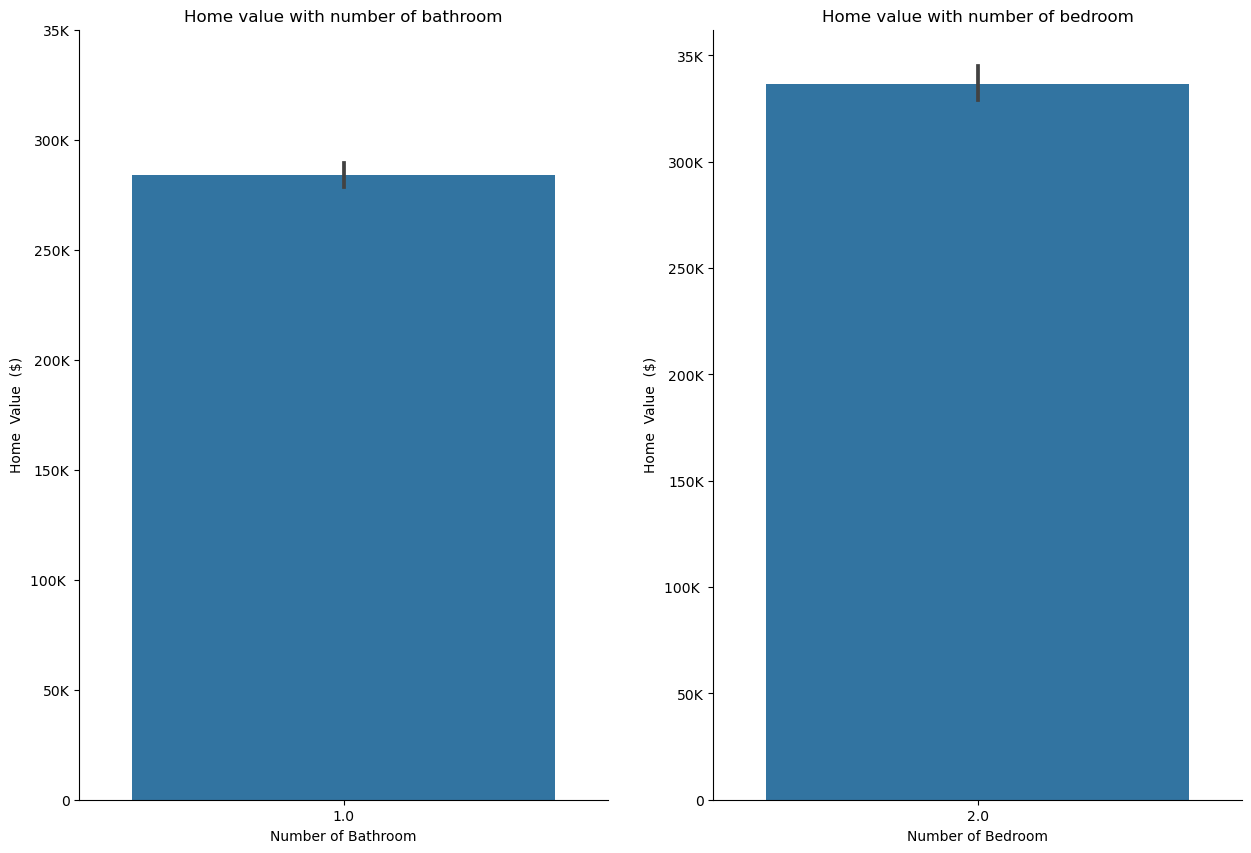

In [28]:
get_barplot_one_bathroom_two_bedroom(train)

In [29]:
def ind_t_test_one_bathroom_two_bedroom(train):
    
    '''takes in a list and a dataframe and runs independent t-test(1_tail,greater than) to compare mean between dataframe attributes'''
    
    # set alpha value to 0.05
    alpha = 0.05
       
    house_with_one_bathroom = train[train.bathroom == 1].tax_amount
    house_with_two_bedroom = train[train.bedroom == 2].tax_amount

     # set null and alternative hypothesis
    null_hypothesis = 'House with one bathroom has less than or equal value to house with two bedroom' 
    alternative_hypothesis = 'House with one bathroom has greater value than house with two bedroom'
    
    # print Null Hypothesis followed by a new line
    print(f'Null Hypothesis: {null_hypothesis}\n')

    # print Alternative Hypothesis followed by a new line
    print(f'Alternative Hypothesis: {alternative_hypothesis}\n')

    # verify assumptions:
        # - independent samples
        # - more than 30 observation
        # -equal Variances

    if house_with_one_bathroom.var() != house_with_two_bedroom .var(): 

        # run independent t-test without equl variances
        t, p = stats.ttest_ind(house_with_one_bathroom, house_with_two_bedroom, equal_var = False)

        # print t-statistic value
        print(f't: {t}')

        # print p-value followed by a new line
        print(f'p: {p}\n')

        if t > 0 and p/2 < alpha:
            print('we reject null hypothesis\n')
            print(alternative_hypothesis)
        else:
            print('We fail to reject null hypothesis\n')
            print(f'It appears that {null_hypothesis}')
    else: 
        # run independent t-test with equal variances
        t, p = stats.ttest_ind(house_with_one_bathroom, house_with_two_bedroom)

        # print t-statistic value
        print(f't: {t}')

        # print p-value followed by a new line
        print(f'p: {p}\n')

        if t > 0 and p/2 < alpha:
            print('we reject Null Hypothesis\n')
            print(alternative_hypothesis)
        else:
            print('We fail to reject Null Hypothesis\n')
            print(f'It appears that {null_hypothesis}')
    print('--------------------------------------------------------------------------------------------\n')


In [30]:
ind_t_test_one_bathroom_two_bedroom(train)

Null Hypothesis: House with one bathroom has less than or equal value to house with two bedroom

Alternative Hypothesis: House with one bathroom has greater value than house with two bedroom

t: -10.913710255250956
p: 1.523217710301919e-27

We fail to reject null hypothesis

It appears that House with one bathroom has less than or equal value to house with two bedroom
--------------------------------------------------------------------------------------------



In [31]:
def ind_t_test_greater_bathroom(train):
    
    '''takes in a list and a dataframe and runs independent t-test(1_tail,greater than) to compare mean between dataframe attributes'''
    
    # set alpha value to 0.05
    alpha = 0.05
       
    house_above_median_bathroom = train[train.bathroom > train.bathroom.median()].tax_amount
    house_below_median_bathroom = train[train.bathroom <train.bathroom.median()].tax_amount

     # set null and alternative hypothesis
    null_hypothesis = 'House with above median bathroom have less than or equl value to house with below median bathroom' 
    alternative_hypothesis = 'House with above median bathroom have greater value than house with below median bathroom'
    
    # print Null Hypothesis followed by a new line
    print(f'Null Hypothesis: {null_hypothesis}\n')

    # print Alternative Hypothesis followed by a new line
    print(f'Alternative Hypothesis: {alternative_hypothesis}\n')

    # verify assumptions:
        # - independent samples
        # - more than 30 observation
        # -equal Variances

    if house_above_median_bathroom .var() != house_below_median_bathroom .var(): 

        # run independent t-test without equl variances
        t, p = stats.ttest_ind(house_above_median_bathroom, house_below_median_bathroom, equal_var = False)

        # print t-statistic value
        print(f't: {t}')

        # print p-value followed by a new line
        print(f'p: {p}\n')

        if t > 0 and p/2 < alpha:
            print('we reject null hypothesis\n')
            print(alternative_hypothesis)
        else:
            print('We fail to reject null hypothesis\n')
            print(f'It appears that {null_hypothesis}')
    else: 
        # run independent t-test with equal variances
        t, p = stats.ttest_ind(house_above_median_bathroom, house_below_median_bathroom)

        # print t-statistic value
        print(f't: {t}')

        # print p-value followed by a new line
        print(f'p: {p}\n')

        if t > 0 and p/2 < alpha:
            print('we reject Null Hypothesis\n')
            print(alternative_hypothesis)
        else:
            print('We fail to reject Null Hypothesis\n')
            print(f'It appears that {null_hypothesis}')
    print('--------------------------------------------------------------------------------------------\n')


In [32]:
def ind_t_test_greater_bedroom(train):
    
    '''takes in a list and a dataframe and runs independent t-test(1_tail,greater than) to compare mean between dataframe attributes'''
    
    # set alpha value to 0.05
    alpha = 0.05
       
    house_above_median_bedroom = train[train.bedroom > train.bedroom.median()].tax_amount
    house_below_median_bedroom = train[train.bedroom <train.bedroom.median()].tax_amount

     # set null and alternative hypothesis
    null_hypothesis = 'House with above median bedroom have less than or equl value to house with below median bedroom' 
    alternative_hypothesis = 'House with above median bedroom have greater value than house with below median bedroom'
    
    # print Null Hypothesis followed by a new line
    print(f'Null Hypothesis: {null_hypothesis}\n')

    # print Alternative Hypothesis followed by a new line
    print(f'Alternative Hypothesis: {alternative_hypothesis}\n')

    # verify assumptions:
        # - independent samples
        # - more than 30 observation
        # -equal Variances

    if house_above_median_bedroom .var() != house_below_median_bedroom .var(): 

        # run independent t-test without equl variances
        t, p = stats.ttest_ind(house_above_median_bedroom, house_below_median_bedroom, equal_var = False)

        # print t-statistic value
        print(f't: {t}')

        # print p-value followed by a new line
        print(f'p: {p}\n')

        if t > 0 and p/2 < alpha:
            print('we reject null hypothesis\n')
            print(alternative_hypothesis)
        else:
            print('We fail to reject null hypothesis\n')
            print(f'It appears that {null_hypothesis}')
    else: 
        # run independent t-test with equal variances
        t, p = stats.ttest_ind(house_above_median_bedroom, house_below_median_bedroom)

        # print t-statistic value
        print(f't: {t}')

        # print p-value followed by a new line
        print(f'p: {p}\n')

        if t > 0 and p/2 < alpha:
            print('we reject Null Hypothesis\n')
            print(alternative_hypothesis)
        else:
            print('We fail to reject Null Hypothesis\n')
            print(f'It appears that {null_hypothesis}')
    print('--------------------------------------------------------------------------------------------\n')


In [33]:
def get_lmplot(df): 
    plt.figure(figsize=(10,6))
    ax = sns.lmplot(x='sqft',y='tax_amount', data=df.sample(1000),line_kws={'color':'red'})
    plt.xlabel('Area in sqft')
    plt.ylabel('Home  Value  ($)')
    plt.title("Relation of Area with Home Value")
    plt.ticklabel_format(style='plain')
    plt.show()

<Figure size 1000x600 with 0 Axes>

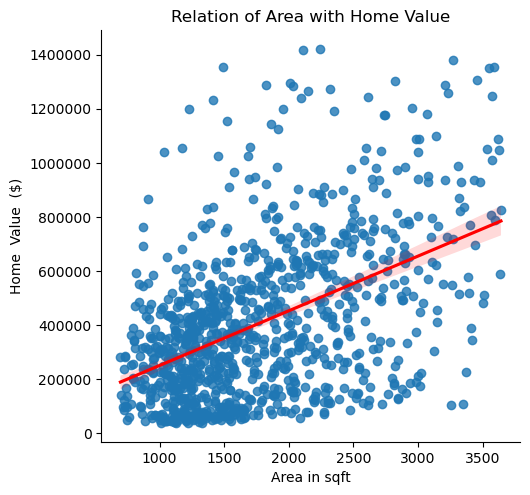

In [34]:
get_lmplot(train)

In [35]:
def corelation_sqft_tax_amount( train):
    '''takes in a list and a dataframe and runs chi-square test to compare relationship of churn 
    with a datframe attributes 
    '''
    
    # set alpha value to 0.05
    alpha = 0.05
   
            
    # set null and alternative hypothesis 
    null_hypothesis = 'There is no linear colrealtion between area and home value'
    alternative_hypothesis = 'There is linear colrealtion between area and home value'

    # run person's correlation test
    r, p = stats.pearsonr(train.sqft, train.tax_amount)

    # print Null Hypothesis followed by a new line
    print(f'Null Hypothesis: {null_hypothesis}\n')

    # print Alternative Hypothesis followed by a new line
    print(f'Alternative Hypothesis: {alternative_hypothesis}\n')

    # print the chi2 value
    print(f'r = {r}') 

    # print the p-value followed by a new line
    print(f'p     = {p}\n')

    if p < alpha:
        print(f'We reject null hypothesis')
        print(alternative_hypothesis)
    else:
        print(f'We fail to reject null hypothesis')
        print(f'There appears to be no significant linear corelation between area and home value')
    print('--------------------------------------------------------------------------------------------\n')


In [36]:
corelation_sqft_tax_amount( train)

Null Hypothesis: There is no linear colrealtion between area and home value

Alternative Hypothesis: There is linear colrealtion between area and home value

r = 0.470969512846164
p     = 0.0

We reject null hypothesis
There is linear colrealtion between area and home value
--------------------------------------------------------------------------------------------



In [37]:
train_scaled, validate_scaled, test_scaled= modelling.scale_data(train, validate, test, 
                                                       columns_to_scale=['bedroom', 'bathroom', 'sqft','Los Angeles','Orange', 'Ventura' ],
                                                       return_scaler=False)

In [38]:
train_scaled.head()

,bathroom,bedroom,sqft,tax_amount,county,Los Angeles,Orange,Ventura,Los Angeles,Orange,Ventura
24005,0.666667,0.75,0.698418,349000.0,Los Angeles,1.0,1.0,0.0,1.0,1.0,0.0
10859,0.333333,0.25,0.420897,793000.0,Los Angeles,1.0,1.0,0.0,1.0,1.0,0.0
40615,0.333333,0.50,0.270600,127619.0,Los Angeles,1.0,1.0,0.0,1.0,1.0,0.0
44400,0.333333,0.50,0.204351,488770.0,Los Angeles,1.0,1.0,0.0,1.0,1.0,0.0
47188,0.333333,0.25,0.237310,305739.0,Orange,0.0,0.0,1.0,0.0,0.0,1.0


In [39]:
#create a function to isolate the target variable
def X_y_split(train, validate, test, target):
    '''
    This function takes in a dataframe and a target variable
    Then it returns the X_train, y_train, X_validate, y_validate, X_test, y_test
    and a print statement with the shape of the new dataframes
    '''  


    X_train = train.drop(columns= ['county', 'tax_amount'])
    y_train = train[[target]]

    X_validate = validate.drop(columns= ['county', 'tax_amount'])
    y_validate = validate[[target]]

    X_test = test.drop(columns= ['county', 'tax_amount'])
    y_test = test[[target]]
        
 
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test



In [40]:
X_train, y_train, X_validate, y_validate, X_test, y_test = X_y_split(train_scaled, validate_scaled, test_scaled, 'tax_amount')

In [41]:
target = 'tax_amount'
# compute baseline
baseline_mean = y_train[target].mean()
baseline_median = y_train[target].median()
    
baseline_mean, baseline_median
    
    

(403154.98074503377, 349214.0)

In [42]:
# def get_baseline(train,validate, target):
#     train['baseline_mean'] = train[target].mean()
#     train['baseline_median'] = train[target].median()
    
#     validate['baseline_mean'] = train[target].mean()
#     train['baseline_median'] = train[target].median()
    
#     print(['baseline_mean'], train['baseline_median'],  validate['baseline_mean'], train['baseline_median'])
       

In [43]:
# train['baseline_mean'] = train[target].mean()
# train['baseline_mean']

In [44]:
# y_train['baseline_mean'] = y_train[target].mean()
# y_train['baseline_mean']

In [45]:
def get_rmse_mean(train,validate, target):
    train['baseline_mean'] = train[target].mean()
    validate['baseline_mean'] = train[target].mean()
    train_RMSE_mean  = mean_squared_error(train[target], train['baseline_mean'], squared=False )
    validae_RMSE_mean = mean_squared_error(validate[target], validate['baseline_mean'], squared=False )
    print('RMSE using mean')
    print(F'train_RMSE: {train_RMSE_mean}')
    print(f'validate RMSE: {validae_RMSE_mean}')
    return train_RMSE_mean, validae_RMSE_mean

In [46]:
train_rmse_mean, validate_rmse_mean  = get_rmse_mean(train, validate,'tax_amount')
train_rmse_mean, validate_rmse_mean

RMSE using mean
train_RMSE: 282783.9723515096
validate RMSE: 276920.1915397434


(282783.9723515096, 276920.1915397434)

In [47]:
def get_rmse_median(train,validate, target):
    train['baseline_median'] = train[target].median()
    validate['baseline_median'] = validate[target].median()
    train_RMSE_median  = mean_squared_error(train[target], train['baseline_median'], squared=False )
    validae_RMSE_median = mean_squared_error(validate[target], validate['baseline_median'], squared=False )
    print('RMSE using median')
    print(F'train_RMSE: {train_RMSE_median}')
    print(f'validate RMSE: {validae_RMSE_median}')
    return train_RMSE_median, validae_RMSE_median

In [48]:
train_rmse_median, validate_rmse_median  = get_rmse_median(train, validate,'tax_amount')
train_rmse_median, validate_rmse_median

RMSE using median
train_RMSE: 287882.6226479039
validate RMSE: 281169.87292888097


(287882.6226479039, 281169.87292888097)

In [49]:

def get_linear_regression(X_train,y_train,X_validate,y_validate, target):
    # create the model object
    lm = LinearRegression()  
    # Fit the model
    lm.fit(X_train, y_train[target])   
    # Predict train
    y_train['prediction_OLS'] = lm.predict(X_train)
    # predict validate 
    y_validate['prediction_OLS'] = lm.predict(X_validate)  
    # evaluate train RMSE
    rmse_train = round (mean_squared_error(y_train[target], y_train['prediction_OLS'],squared=False ), 2)
    # evaluate validate rmse
    rmse_validate = round (mean_squared_error(y_validate[target], y_validate['prediction_OLS'],squared=False), 2)
    
    return rmse_train, rmse_validate


In [50]:
rmse_lm_train, rmse_lm_validate = get_linear_regression(X_train,y_train,X_validate,y_validate, 'tax_amount')
rmse_lm_train, rmse_lm_validate

(245856.22, 241331.46)

In [51]:
def get_lassoLars(X_train,y_train,X_validate,y_validate, target, alpha):
    # create the model object
    lars = LassoLars(alpha)  
    # Fit the model
    lars.fit(X_train, y_train[target])   
    # Predict train
    y_train['prediction_lassoLars'] = lars.predict(X_train)
    # predict validate 
    y_validate['prediction_lassoLars'] = lars.predict(X_validate)  
    # evaluate train RMSE
    rmse_train = round (mean_squared_error(y_train[target], y_train['prediction_lassoLars'],squared=False ), 2)
    # evaluate validate rmse
    rmse_validate = round (mean_squared_error(y_validate[target], y_validate['prediction_lassoLars'],squared=False), 2)
    
    return rmse_train, rmse_validate
    

In [52]:
lassoLars_alpha = []
lassoLars_rmse_train = []
lassoLars_rmse_validate = []
for i in range(0,11): 
    rmse_train, rmse_validate = get_lassoLars(X_train,y_train,X_validate,y_validate, 'tax_amount', alpha=i)
    lassoLars_alpha.append(i)
    lassoLars_rmse_train.append(rmse_train)
    lassoLars_rmse_validate.append(rmse_validate)
    
lassoLars_df = pd.DataFrame({'alpha': lassoLars_alpha,
                            'rmse_train': lassoLars_rmse_train,
                            'rmse_validate': lassoLars_rmse_validate})
    
lassoLars_df['rmse_differnce'] =  lassoLars_df['rmse_train'] - lassoLars_df['rmse_validate']
lassoLars_df

,alpha,rmse_train,rmse_validate,rmse_differnce
0,0,251917.8,246549.84,5367.96
1,1,251917.8,246549.84,5367.96
2,2,251917.8,246549.84,5367.96
3,3,251917.8,246549.84,5367.96
4,4,251917.8,246549.84,5367.96
5,5,251917.8,246549.84,5367.96
6,6,251917.8,246549.84,5367.96
7,7,251917.8,246549.84,5367.96
8,8,251917.8,246549.84,5367.96
9,9,251917.8,246549.84,5367.96


In [53]:
rmse_lars_train, rmse_lars_validate = get_lassoLars(X_train,y_train,X_validate,y_validate, 'tax_amount', 1)
rmse_lars_train, rmse_lars_validate

(251917.8, 246549.84)

In [54]:
def get_tweedie(X_train,y_train,X_validate,y_validate, target, power, alpha):
    # create the model object
    glm = TweedieRegressor(power=power, alpha=alpha)
    # Fit the model
    glm.fit(X_train, y_train[target])   
    # Predict train
    y_train['prediction_GLM'] = glm.predict(X_train)
    # predict validate 
    y_validate['prediction_GLM'] = glm.predict(X_validate)  
    # evaluate train RMSE
    rmse_train = round (mean_squared_error(y_train[target], y_train['prediction_GLM'],squared=False ), 2)
    # evaluate validate rmse
    rmse_validate = round (mean_squared_error(y_validate[target], y_validate['prediction_GLM'],squared=False), 2)
    
    return rmse_train, rmse_validate
    

In [55]:
tweedie_alpha = []
tweedie_rmse_train = []
tweedie_rmse_validate = []
for i in range(0,11): 
    rmse_train, rmse_validate = get_tweedie(X_train,y_train,X_validate,y_validate, 'tax_amount', power = 0, alpha=i)
    tweedie_alpha.append(i)
    tweedie_rmse_train.append(rmse_train)
    tweedie_rmse_validate.append(rmse_validate)
    
tweedie_df = pd.DataFrame({'alpha': tweedie_alpha,
                            'rmse_train': tweedie_rmse_train,
                            'rmse_validate': tweedie_rmse_validate})
    
tweedie_df['rmse_differnce'] =  tweedie_df['rmse_train'] - tweedie_df['rmse_validate']
tweedie_df

,alpha,rmse_train,rmse_validate,rmse_differnce
0,0,245849.76,241300.19,4549.57
1,1,275134.61,269713.32,5421.29
2,2,277871.71,272329.70,5542.01
3,3,279103.28,273489.28,5614.00
4,4,279828.10,274167.91,5660.19
5,5,280310.45,274618.33,5692.12
6,6,280655.94,274940.49,5715.45
7,7,280916.06,275182.84,5733.22
8,8,281119.17,275371.97,5747.20
9,9,281282.25,275523.76,5758.49


In [56]:
rmse_glm_train, rmse_glm_validate = get_tweedie(X_train,y_train,X_validate,y_validate, target, 1, 0)
rmse_glm_train, rmse_glm_validate

(245395.21, 240971.32)

In [57]:
def get_polynomial(X_train,y_train,X_validate,y_validate, target, degree):
    
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree)

    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train)

    # transform X_validate_scaled 
    X_validate_degree2 = pf.transform(X_validate)
    
    # create the model object
    lm2 = LinearRegression()
    # Fit the model
    lm2.fit(X_train_degree2, y_train[target])   
    # Predict train
    y_train['prediction_polynomial'] = lm2.predict(X_train_degree2)
    # predict validate 
    y_validate['prediction_polynomial'] = lm2.predict(X_validate_degree2)  
    # evaluate train RMSE
    rmse_train = round (mean_squared_error(y_train[target], y_train['prediction_polynomial'],squared=False ), 2)
    # evaluate validate rmse
    rmse_validate = round (mean_squared_error(y_validate[target], y_validate['prediction_polynomial'],squared=False), 2)
    
    return rmse_train, rmse_validate

In [58]:
polynomial_degree = []
polynomial_rmse_train = []
polynomial_rmse_validate = []
for i in range(1,5): 
    rmse_train, rmse_validate = get_polynomial(X_train,y_train,X_validate,y_validate, 'tax_amount', degree=i)
    polynomial_degree.append(i)
    polynomial_rmse_train.append(rmse_train)
    polynomial_rmse_validate.append(rmse_validate)
    
polynomial_df = pd.DataFrame({'degree': polynomial_degree,
                            'rmse_train': polynomial_rmse_train,
                            'rmse_validate': polynomial_rmse_validate})
    
polynomial_df['rmse_differnce'] =  polynomial_df['rmse_train'] - polynomial_df['rmse_validate']
polynomial_df

,degree,rmse_train,rmse_validate,rmse_differnce
0,1,245857.32,241340.72,4516.60
1,2,244798.14,240173.04,4625.10
2,3,244170.86,239729.31,4441.55
3,4,244054.70,240088.95,3965.75


In [59]:
rmse_poly_train, rmse_poly_validate= get_polynomial(X_train,y_train,X_validate,y_validate,'tax_amount', 3)
rmse_poly_train, rmse_poly_validate

(244170.86, 239729.31)

In [60]:
rmse_glm_train, rmse_glm_validate = get_tweedie(X_train,y_train,X_validate,y_validate, target, 1, 0)
rmse_glm_train, rmse_glm_validate

(245395.21, 240971.32)

In [61]:
rmse_lars_train, rmse_lars_validate = get_lassoLars(X_train,y_train,X_validate,y_validate, 'tax_amount', 1)
rmse_lars_train, rmse_lars_validate

(251917.8, 246549.84)

In [62]:
rmse_lm_train, rmse_lm_validate = get_linear_regression(X_train,y_train,X_validate,y_validate, 'tax_amount')
rmse_lm_train, rmse_lm_validate

(245856.22, 241331.46)

In [63]:
metric_df = pd.DataFrame({'model': ['baseline', 'LinearRegreesion', 'LassoLars(alpha=1)', 'TweedieRegreesor(power=0, alpha=0)','Polynomial Regression(degree=3)'],
                         'train_RMSE': [train_rmse_mean, rmse_lm_train, rmse_lars_train, rmse_glm_train, rmse_poly_train],
                         'validate_RMSE': [validate_rmse_mean, rmse_lm_validate, rmse_lars_validate, rmse_glm_validate, rmse_poly_validate]})
metric_df['difference'] = metric_df['train_RMSE'] - metric_df['validate_RMSE']
metric_df

,model,train_RMSE,validate_RMSE,difference
0,baseline,282783.972352,276920.19154,5863.780812
1,LinearRegreesion,245856.220000,241331.46000,4524.760000
2,LassoLars(alpha=1),251917.800000,246549.84000,5367.960000
3,"TweedieRegreesor(power=0, alpha=0)",245395.210000,240971.32000,4423.890000
4,Polynomial Regression(degree=3),244170.860000,239729.31000,4441.550000


In [64]:
def rmse_models():
    train_rmse_mean, validate_rmse_mean = get_rmse_mean(train, validate,'tax_amount')
    rmse_lm_train, rmse_lm_validate = get_linear_regression(X_train,y_train,X_validate,y_validate, 'tax_amount')
    rmse_lars_train, rmse_lars_validate = get_lassoLars(X_train,y_train,X_validate,y_validate, 'tax_amount', 1)
    rmse_glm_train, rmse_glm_validate = get_tweedie(X_train,y_train,X_validate,y_validate, target, 1, 0)
    rmse_poly_train, rmse_poly_validate= get_polynomial(X_train,y_train,X_validate,y_validate,'tax_amount', 3)
    index = ['baseline', 'LinearRegreesion', 'LassoLars(alpha=1)', 'TweedieRegreesor(power=0, alpha=0)','Polynomial Regression(degree=3)']
    metric_df = pd.DataFrame({'train_RMSE':[train_rmse_mean, rmse_lm_train, rmse_lars_train, rmse_glm_train, rmse_poly_train],
                         'validate_RMSE': [validate_rmse_mean, rmse_lm_validate, rmse_lars_validate, rmse_glm_validate, rmse_poly_validate]},index=index)
    return metric_df


In [65]:
rmse_df = rmse_models()
rmse_df 

RMSE using mean
train_RMSE: 282783.9723515096
validate RMSE: 276920.1915397434


,train_RMSE,validate_RMSE
baseline,282783.972352,276920.19154
LinearRegreesion,245856.220000,241331.46000
LassoLars(alpha=1),251917.800000,246549.84000
"TweedieRegreesor(power=0, alpha=0)",245395.210000,240971.32000
Polynomial Regression(degree=3),244170.860000,239729.31000


In [66]:
def plot_bar_rmse(df ):
    ax = df.plot.bar(rot=75)
    ax.spines[['right', 'top']].set_visible(False)
    plt.title("Comparisons of RMSE")
    plt.ylabel('Home  Value  ($)')
    plt.ylim(200000, 290000)
    



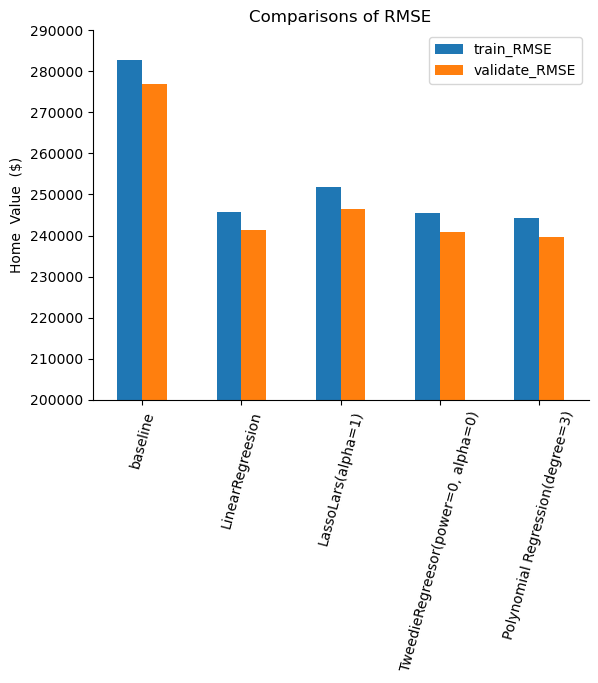

In [67]:
plot_bar_rmse(rmse_df)

In [68]:
def get_polynomial_test(X_train,y_train,X_test,y_test, target, degree):
    
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree)

    # fit and transform X_train_scaled
    X_train_degree = pf.fit_transform(X_train)

    # transform X_validate_scaled 
    X_test_degree = pf.transform(X_test)
    
    # create the model object
    lm = LinearRegression()
    # Fit the model
    lm.fit(X_train_degree, y_train[target])   

    # predict test 
    y_test['prediction_polynomial_test'] = lm.predict(X_test_degree)  
    # evaluate test rmse
    rmse_test = round (mean_squared_error(y_test[target], y_test['prediction_polynomial_test'],squared=False), 2)
    r2 = explained_variance_score(y_test[target], y_test['prediction_polynomial_test'])
    print('Using polynomial Regresion on test')
    print(f'RMSE : { rmse_test}')
    print(f'r2 : {r2}')
    return  rmse_test

In [69]:
get_polynomial_test(X_train,y_train,X_test,y_test, 'tax_amount', 3)


Using polynomial Regresion on test
RMSE : 243281.01
r2 : 0.2541388992917609


243281.01

In [70]:
y_train

,tax_amount,prediction_OLS,prediction_lassoLars,prediction_GLM,prediction_polynomial
24005,349000.0,599506.899954,547115.217302,585696.207826,566290.980745
10859,793000.0,501074.899954,428749.852896,465787.350314,510930.980745
40615,127619.0,344530.899954,361601.857750,336303.989869,336658.980745
44400,488770.0,300370.899954,332003.728311,306823.956866,295666.980745
47188,305739.0,440722.899954,371052.478489,417773.586475,402194.980745
...,...,...,...,...,...
48011,195806.0,333138.899954,353944.630233,328416.101747,325938.980745
47776,161012.0,231506.899954,271067.570280,259206.112663,255026.980745
20304,205321.0,380562.899954,367980.478489,368389.149934,366546.980745
20066,194657.0,203730.899954,252513.518989,244719.842578,236530.980745


In [71]:
y_test

,tax_amount,prediction_polynomial_test
14082,362126.0,454994.980745
26213,105352.0,264050.980745
18180,93148.0,324658.980745
39421,616000.0,407570.980745
44544,367771.0,289970.980745
...,...,...
40800,585788.0,603154.980745
41866,441655.0,656530.980745
49496,784529.0,951890.980745
12310,289169.0,448850.980745
